In [3]:
# Import all this
import clean_up_data
import regression_df
import get_data
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import copy
from itertools import chain, combinations

# DO NOT run below code. Scroll down to the read_csv statements instead

In [3]:
# set an n value for number of games to average over
n = 10

In [108]:
# get the data real quick (train on 2016,2017, test on 2018)
games15 = get_data.get_data_for_year(2015)
games16 = get_data.get_data_for_year(2016)

games17 = get_data.get_data_for_year(2017)

dic15 = clean_up_data.main(games15)
dic16 = clean_up_data.main(games16)

dic17 = clean_up_data.main(games17)

regr15 = regression_df.main(dic15)
regr16 = regression_df.main(dic16)

regr17 = regression_df.main(dic17)


[INFO] Lost 503 values.
[INFO] Lost 64 values.
[INFO] Lost 108 values.


In [109]:
# quick function to turn our regression data ready for actual regression

def prepare(regr):
    home = regr[regr['home']]
    away = regr[regr['home'] == False]
    # drop columns that don't need repeating
    away.drop(['home','t1_score', 't2_score', 'game_spread',
       'game_OU', 't1_ML', 't2_ML'], axis = 1, inplace = True)
    home.drop(['home'], axis = 1, inplace = True)
    return home.merge(away, on = 'game_id', suffixes=('_home', '_away'))    

In [110]:
data15 = prepare(regr15)
data16 = prepare(regr16)

data17 = prepare(regr17)

train = pd.concat((data15, data16))
test = data17

## Run code starting here

In [11]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Breakdown of prepared regression data: Our columns are


       'game_id', 'pts_home', 'a_pts_home', 'poss_home', 'a_poss_home',
       'ort_home', 'drt_home', 'OU_home', 'efg_home', 'a_efg_home',
       'ast_pct_home', 'win_home', 
       
       't1_score', 't2_score', 'game_spread',
       'game_OU', 't1_ML', 't2_ML',
       
       'pts_away', 'a_pts_away', 'poss_away',
       'a_poss_away', 'ort_away', 'drt_away', 'OU_away', 'efg_away',
       'a_efg_away', 'ast_pct_away', 'win_away'
       
The first and third parts are the home & away statistics, averaged (or calculated) over n games.The prefix a_ means the statistics is calculated for the team's opponents. 

The middle part contains the details of the game results as well as gambling info for the games.

# First we create algorithms for spread prediction

# Algorithm 1

We perform a linear regression on the cover, using game stats which we deem important

In [15]:
# Get relevent columns and split up our data
x_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
x_cols = [x + '_home' for x in x_cols] + [x + '_away' for x in x_cols]
x_train = train[x_cols]
x_test = test[x_cols]
y_train = train['t1_score'] - train['t2_score'] - train['game_spread']
y_test = test['t1_score'] - test['t2_score'] - test['game_spread']

In [16]:
# Build and train our model 
algo_1 = LinearRegression()
algo_1.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

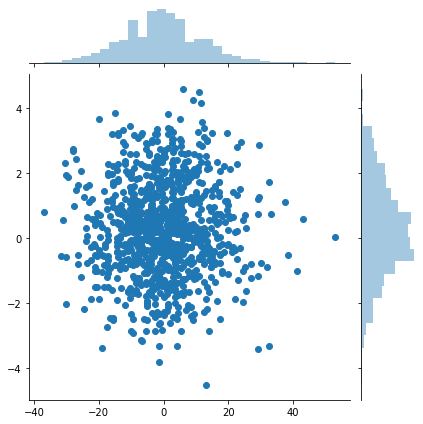

In [18]:
# Predict our data
algo_1_pred = algo_1.predict(x_test)

# Plot expected vs actual
sns.jointplot(x = y_test, y = algo_1_pred)

In [20]:
# Print our classification report
print(classification_report(y_test > 0, algo_1_pred > 0))

              precision    recall  f1-score   support

       False       0.54      0.45      0.49       519
        True       0.47      0.55      0.51       447

    accuracy                           0.50       966
   macro avg       0.50      0.50      0.50       966
weighted avg       0.51      0.50      0.50       966



Awesome, didn't work at all!

# Algorithm 2
Now we predict the points total for both teams, and see if that covers the spread!

In [21]:
# Get relevent columns and split up our data
x_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
x_cols = [x + '_home' for x in x_cols] + [x + '_away' for x in x_cols]
x_train = train[x_cols]
x_test = test[x_cols]
y_train = train['t1_score'] - train['t2_score']
y_test = test['t1_score'] - test['t2_score']

In [22]:
# Build and train our model 
algo_2 = LinearRegression()
algo_2.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

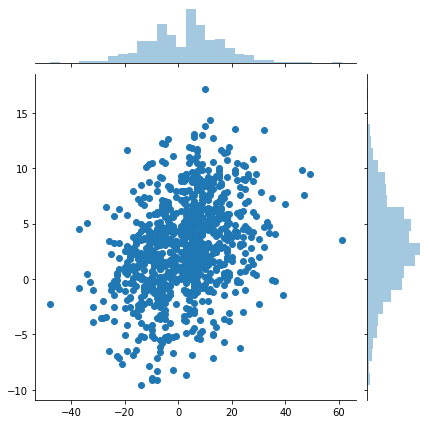

In [23]:
# Predict our data
algo_2_pred = algo_2.predict(x_test)

# Plot expected vs actual
sns.jointplot(x = y_test, y = algo_2_pred)

In [25]:
# Print our classification report
print(classification_report(y_test > test['game_spread'], algo_2_pred > test['game_spread']))

              precision    recall  f1-score   support

       False       0.56      0.53      0.54       519
        True       0.49      0.52      0.50       447

    accuracy                           0.52       966
   macro avg       0.52      0.52      0.52       966
weighted avg       0.53      0.52      0.53       966



52%, unreal!

# Algorithm 3

This time, we use the data to predict what the spread is, and if our predicted spread is higher than the actual spread, we bet on the home team (lower: bet on away).

In [177]:
# Get relevent columns and split up our data
x_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
x_cols = [x + '_home' for x in x_cols] + [x + '_away' for x in x_cols]
x_train = train[x_cols]
x_test = test[x_cols]
y_train = train['game_spread']
y_test = test['game_spread']

In [29]:
# Build and train our model 
algo_3 = LinearRegression()
algo_3.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

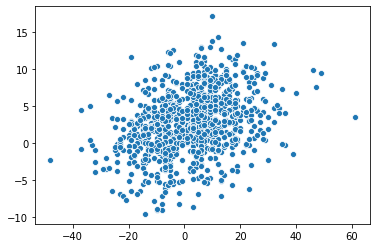

In [30]:
# Predict our data
algo_3_pred = algo_3.predict(x_test)

# Plot expected vs actual
sns.scatterplot(x = y_test, y = algo_3_pred)

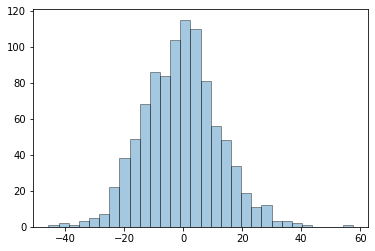

In [31]:
# Plot the distribution between expected - predicted
sns.distplot(y_test - algo_3_pred, bins = 30, kde = False, norm_hist = False, hist_kws = {'edgecolor' : 'black'})

In [36]:
# Calulcate cover and print out classification report
cover = (test['t1_score'] - test['t2_score'] - test['game_spread']) > 0

# Print our classification report
print(classification_report(cover, algo_3_pred > test['game_spread']))

NameError: name 'pred' is not defined

SHIT

# Algorithm 4

Now we just use a logistic regression to classify cover

In [47]:
# Get relevent columns and split up our data
x_cols = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
x_cols = [x + '_home' for x in x_cols] + [x + '_away' for x in x_cols]
x_train = train[x_cols]
x_test = test[x_cols]
y_train = (train['t1_score'] - train['t2_score'] - train['game_spread']) > 0
y_test = (test['t1_score'] - test['t2_score'] - test['game_spread']) > 0

In [48]:
# Build and train our model 
algo_4 = LogisticRegression()
algo_4.fit(x_train, y_train)

/Users/sidpremkumar/Documents/Projects/MoneyBall-Statistics/venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
# Predict our data
algo_4_pred = algo_4.predict(x_test)

# Print our classification report
print(classification_report(y_test, algo_4_pred))

              precision    recall  f1-score   support

       False       0.54      0.49      0.51       519
        True       0.47      0.52      0.49       447

    accuracy                           0.50       966
   macro avg       0.50      0.50      0.50       966
weighted avg       0.51      0.50      0.50       966



trash!

# Algorithm 5
Now we use a random forest to classify

In [235]:
from sklearn.ensemble import RandomForestClassifier

In [238]:
# Get relevent columns and split up our data
x_col = ['pts', 'a_pts', 'poss', 'a_poss',
   'ort', 'drt', 'efg', 'a_efg',
   'ast_pct']
x_col = [x + '_home' for x in x_col] + [x + '_away' for x in x_col]
x_train = train[x_col]
x_test = test[x_col]
y_train = (train['t1_score'] - train['t2_score'] - train['game_spread']) > 0
y_test = (test['t1_score'] - test['t2_score'] - test['game_spread']) > 0

In [239]:
# Build and Fit our model
algo_5 = RandomForestClassifier(n_estimators = 150)
algo_5.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [245]:
# Get our predictions
algo_5_pred = algo_5.predict(x_test)

In [246]:
# Print our classifcation report
print(classification_report(y_test, algo_5_pred))

              precision    recall  f1-score   support

       False       0.56      0.58      0.57       519
        True       0.49      0.46      0.47       447

    accuracy                           0.52       966
   macro avg       0.52      0.52      0.52       966
weighted avg       0.52      0.52      0.52       966



# Algorithm 6
Combine them all! 

In [247]:
def calculate_overlap(arrays):
    """Helper function to calculate overlap on an array of arrays"""
    try:
        ret = np.array([True for x in range(len(arrays[0]))])
        # Grab our first array 
        start_array = arrays[0]
        for x in range(1, len(arrays)):
            bool_one = (start_array == arrays[x])
            ret = (ret & bool_one)
        return ret
    except:
        return []
                
def powerset(iterable):
    """Helper function to get permutations"""
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def create_name(name):
    """Helper function to make name"""
    ret = ""
    for char in name: 
        ret += char
    return ret
        
    

In [249]:
# Get the output for algoritum 1
algo_1_bet = (algo_1_pred > 0)
algo_2_bet = (algo_2_pred > test['game_spread'])
algo_3_bet = (algo_3_pred > test['game_spread'])
algo_4_bet = algo_4_pred
algo_5_bet = algo_5_pred

# Calculate the result for all the permuatations and see where they overlap
permutations = list(powerset([algo_1_bet, algo_2_bet, algo_3_bet, algo_4_bet, algo_5_bet]))
permutations_name = list(powerset("12345"))
algo_6_pred = {}
for index in range(1, len(permutations)):
    name = permutations_name[index]
    overlap = calculate_overlap(permutations[index])
    sample_size = pd.Series(overlap).value_counts()[True]
    algo_6_pred[create_name(name)] = {
        'overlap': overlap,
        'sample_size': sample_size,
    }
temp = algo_6_pred


In [252]:
# Compare the values to actual
y_test = (test['t1_score'] - test['t2_score'] - test['game_spread']) > 0
for index in range(len(permutations)):
    name = permutations_name[index]
    if name:
        overlap = algo_6_pred[create_name(name)]['overlap']
        if "1" in create_name(name):
            pred = algo_1_bet
        elif "2" in create_name(name):
            pred = algo_2_bet
        elif "3" in create_name(name):
            pred = algo_3_bet
        elif "4" in create_name(name):
            pred = algo_4_bet
        elif "5" in create_name(name):
            pred = algo_5_bet
        corectness = (y_test[overlap] == pred[overlap])
        number_of_correct = pd.Series(corectness).value_counts()[True]
        number_of_false = pd.Series(corectness).value_counts()[False]
        algo_6_pred[create_name(name)]['correctness'] = corectness
        algo_6_pred[create_name(name)]['number_of_correct'] = number_of_correct
        algo_6_pred[create_name(name)]['win_percentage'] = number_of_correct / algo_6_pred[create_name(name)]['sample_size'] 
        algo_6_pred[create_name(name)]['money_won'] = number_of_correct - (1.1*number_of_false)
        
        

In [255]:
max = -1
max_money = -1
max_sample_size = -1
for entry, value in algo_6_pred.items():
    print(f"Entry: {entry}")
    print(f"Win Percentage: {value['win_percentage']}")
    print(f"Sample Size: {value['sample_size']}")
    print(f"Monney Won: {value['money_won']}")
    if value['win_percentage'] > max:
        max = value['win_percentage']
        max_sample_size = value['sample_size']
    if value['money_won'] > max_money:
        max_money = value['money_won']
print(f"Max: {max} with Sample Size: {max_sample_size}")
print(f"Max Money Won: {max_money}")

Entry: 1
Win Percentage: 0.4989648033126294
Sample Size: 966
Monney Won: -50.40000000000009
Entry: 2
Win Percentage: 0.5248447204968945
Sample Size: 966
Monney Won: 2.099999999999966
Entry: 3
Win Percentage: 0.5248447204968945
Sample Size: 966
Monney Won: 2.099999999999966
Entry: 4
Win Percentage: 0.5020703933747412
Sample Size: 966
Monney Won: -44.10000000000002
Entry: 5
Win Percentage: 0.5248447204968945
Sample Size: 966
Monney Won: 2.099999999999966
Entry: 12
Win Percentage: 0.5191986644407346
Sample Size: 599
Monney Won: -5.800000000000011
Entry: 13
Win Percentage: 0.5191986644407346
Sample Size: 599
Monney Won: -5.800000000000011
Entry: 14
Win Percentage: 0.5006289308176101
Sample Size: 795
Monney Won: -38.700000000000045
Entry: 15
Win Percentage: 0.5199306759098787
Sample Size: 577
Monney Won: -4.7000000000000455
Entry: 23
Win Percentage: 0.5248447204968945
Sample Size: 966
Monney Won: 2.099999999999966
Entry: 24
Win Percentage: 0.5220338983050847
Sample Size: 590
Monney Won: -2.